In [24]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [25]:
import pathlib

dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file("flower_photos.tar", origin=dataset_url, extract=True)
data_dir = pathlib.Path(data_dir).with_suffix("")

In [26]:
image_count = len(list(data_dir.glob("*/*.jpg")))
image_count

3670

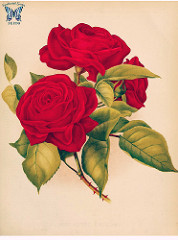

In [27]:
roses = list(data_dir.glob("roses/*"))
image = PIL.Image.open(str(roses[0]))
image

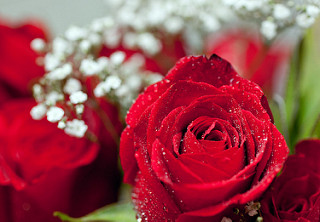

In [28]:
PIL.Image.open(str(roses[99]))

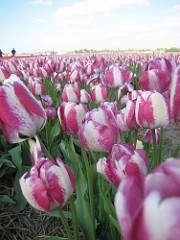

In [29]:
tulips = list(data_dir.glob("tulips/*"))
PIL.Image.open(str(tulips[0]))

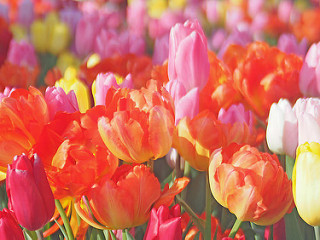

In [30]:
PIL.Image.open(str(tulips[99]))

In [31]:
batch_size = 32
img_height=180
img_width=180

In [32]:
train_ds=tf.keras.utils.image_dataset_from_directory(data_dir,validation_split=0.2,subset="training", seed=123,image_size=(img_height,img_width),batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [33]:
val_ds=tf.keras.utils.image_dataset_from_directory(data_dir,validation_split=0.2,subset="validation", seed=123,image_size=(img_height,img_width),batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [34]:
class_names = train_ds.class_names
class_names

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

2024-07-30 16:18:08.442230: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


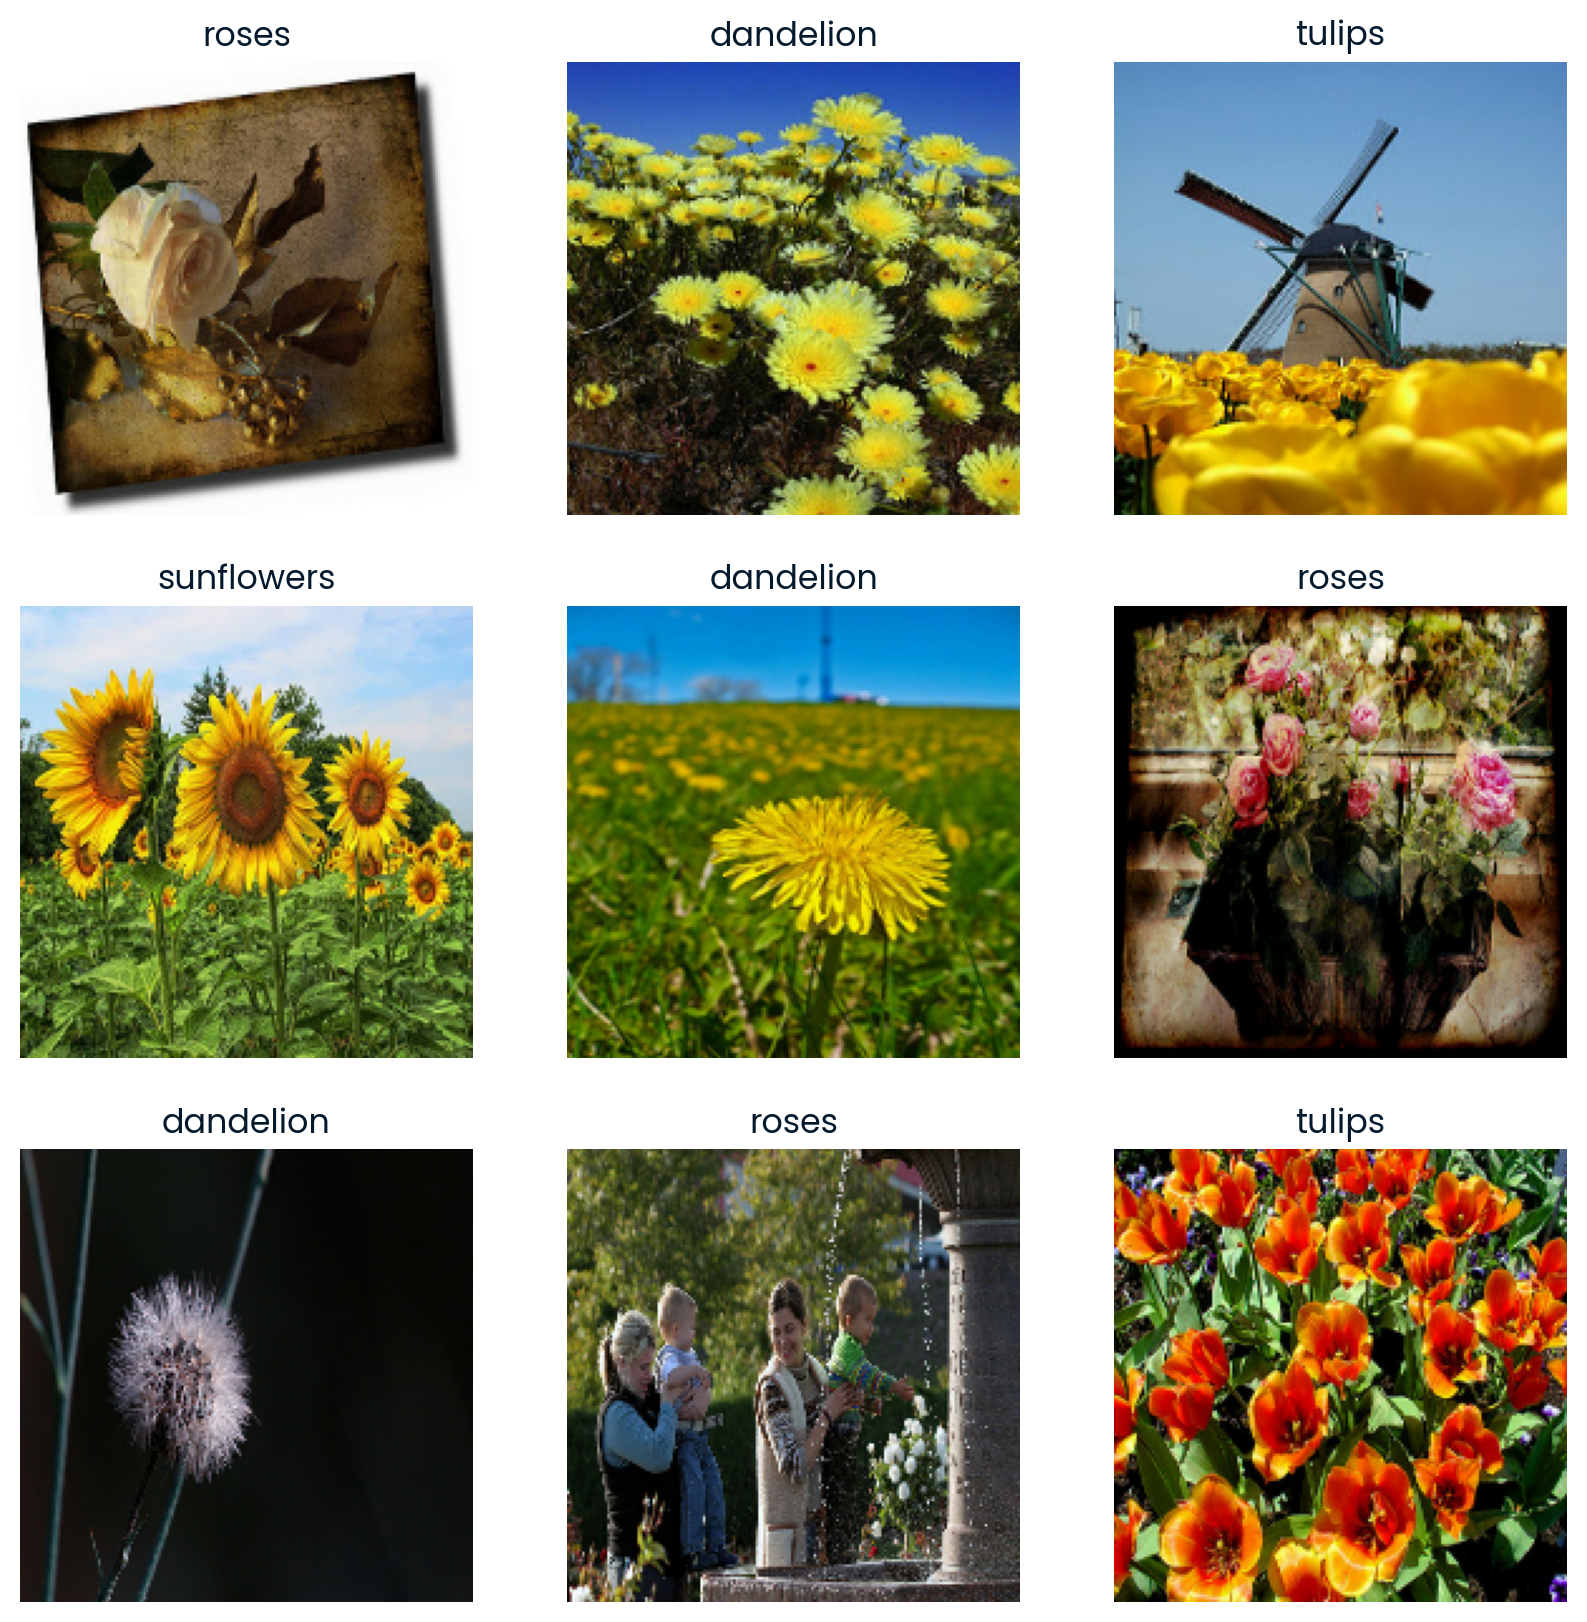

In [35]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(10,10))
for images,labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
plt.show()

In [36]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 180, 180, 3)
(32,)


In [37]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [38]:
normalization_layer = layers.Rescaling(1./255)

In [39]:
# normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x),y))
# image_batch,labels_batch = next(iter(normalized_ds))
# first_image = image_batch[0]
# print(np.min(first_image), np.max(first_image))

In [44]:
num_classes = len(class_names)

model = Sequential([
    layers.Rescaling(1./255, input_shape = (img_height,img_width,3)),
    layers.Conv2D(16,3, padding="same", activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32,3,padding="same", activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64,3,padding="same", activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes)
])

In [46]:
model.compile(optimizer="adam", loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),metrics=["accuracy"])

In [47]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_6 (Rescaling)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 180, 180, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 90, 90, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 90, 90, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 45, 45, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 30976)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │     3,965,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,989,285 (15.22 MB)

 Trainable params: 3,989,285 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

In [49]:
epochs=10
history = model.fit(train_ds,validation_data = val_ds,epochs=epochs)

Epoch 1/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 21s 215ms/step - accuracy: 0.3594 - loss: 1.4724 - val_accuracy: 0.5831 - val_loss: 1.0291
Epoch 2/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 20s 212ms/step - accuracy: 0.6116 - loss: 0.9685 - val_accuracy: 0.5872 - val_loss: 0.9860
Epoch 3/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 20s 220ms/step - accuracy: 0.6961 - loss: 0.8053 - val_accuracy: 0.6322 - val_loss: 0.9511
Epoch 4/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 19s 212ms/step - accuracy: 0.7869 - loss: 0.5836 - val_accuracy: 0.6526 - val_loss: 0.9317
Epoch 5/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 19s 211ms/step - accuracy: 0.8691 - loss: 0.3682 - val_accuracy: 0.6621 - val_loss: 0.9896
Epoch 6/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 20s 212ms/step - accuracy: 0.9440 - loss: 0.1974 - val_accuracy: 0.6512 - val_loss: 1.3040
Epoch 7/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 20s 212ms/step - accuracy: 0.9719 - loss: 0.1084 - val_accuracy: 0.6635 - val_loss: 1.3643
Epoch 8/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 20s 212ms/step - accuracy: 0.9894 - loss: 0.0398 - val_accu

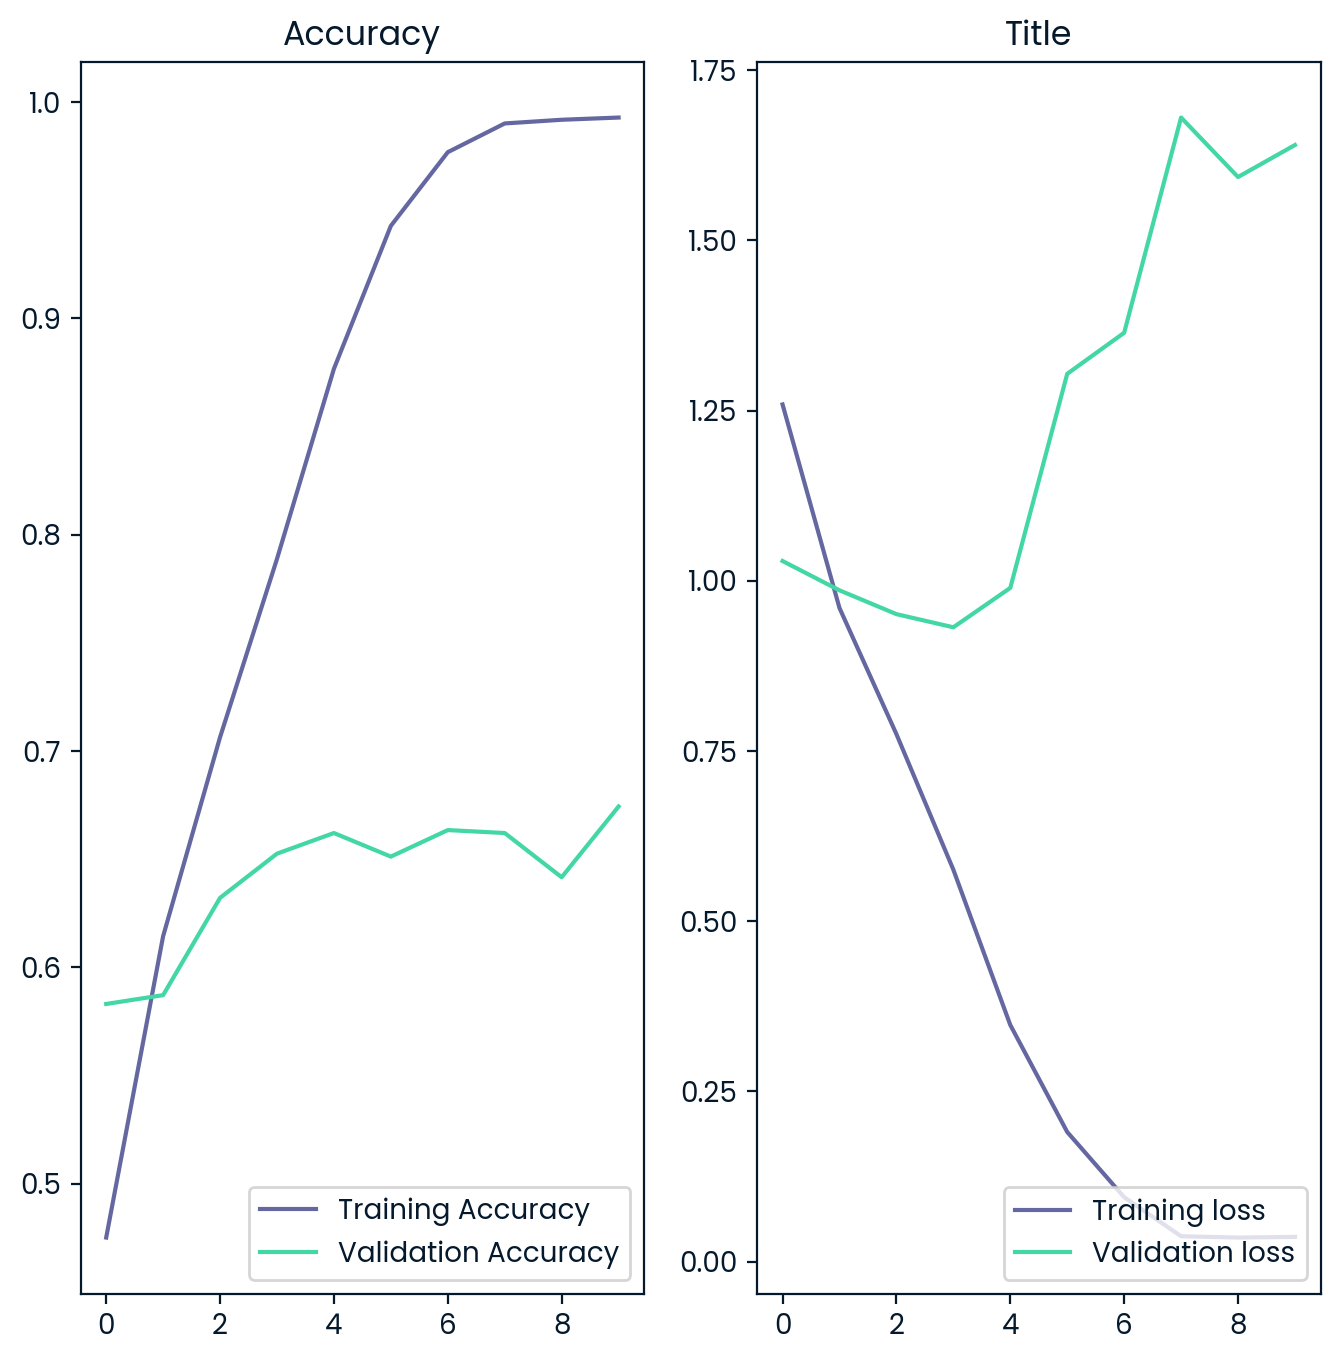

In [57]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

loss = history.history["loss"]
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(epochs_range,acc, label = "Training Accuracy")
plt.plot(epochs_range, val_acc, label = "Validation Accuracy")
plt.legend(loc="lower right")
plt.title("Accuracy")

plt.subplot(1,2,2)
plt.plot(epochs_range,loss, label = "Training loss")
plt.plot(epochs_range, val_loss, label = "Validation loss")
plt.legend(loc="lower right")
plt.title("Title")

plt.show()


Using data Augmentation

In [58]:
data_augmentation = keras.Sequential(
[
    layers.RandomFlip("horizantal",input_shape=(img_height,img_width,3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

2024-07-30 16:52:11.199720: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


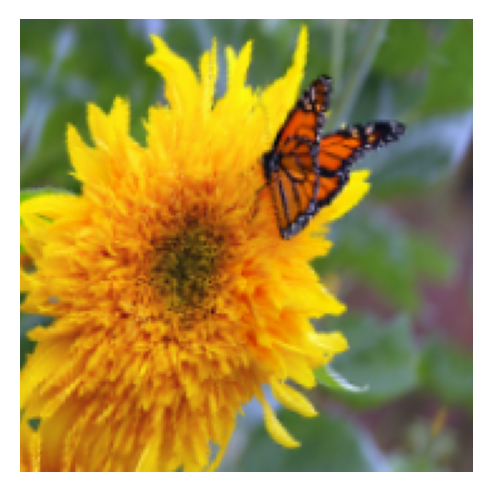

In [64]:
plt.figure(figsize=(10,10))
for images,_ in train_ds.take(1):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3,3,i+1)
    plt.imshow(augmented_images[i].numpy().astype("uint8"))
    plt.axis("off")
plt.show()

In [65]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])


In [66]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [67]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_1 (Sequential)       │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_7 (Rescaling)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ outputs (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [68]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)


Epoch 1/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 23s 236ms/step - accuracy: 0.2856 - loss: 1.6190 - val_accuracy: 0.4687 - val_loss: 1.2211
Epoch 2/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 21s 231ms/step - accuracy: 0.5570 - loss: 1.0843 - val_accuracy: 0.5586 - val_loss: 1.0977
Epoch 3/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 22s 236ms/step - accuracy: 0.6226 - loss: 0.9701 - val_accuracy: 0.6308 - val_loss: 0.9692
Epoch 4/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 21s 233ms/step - accuracy: 0.6480 - loss: 0.9088 - val_accuracy: 0.6553 - val_loss: 0.9368
Epoch 5/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 22s 235ms/step - accuracy: 0.6933 - loss: 0.8104 - val_accuracy: 0.6649 - val_loss: 0.8772
Epoch 6/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 21s 232ms/step - accuracy: 0.6961 - loss: 0.7807 - val_accuracy: 0.6594 - val_loss: 0.8552
Epoch 7/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 21s 232ms/step - accuracy: 0.7259 - loss: 0.7230 - val_accuracy: 0.6717 - val_loss: 0.8545
Epoch 8/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 21s 231ms/step - accuracy: 0.7527 - loss: 0.6509 - val_accu

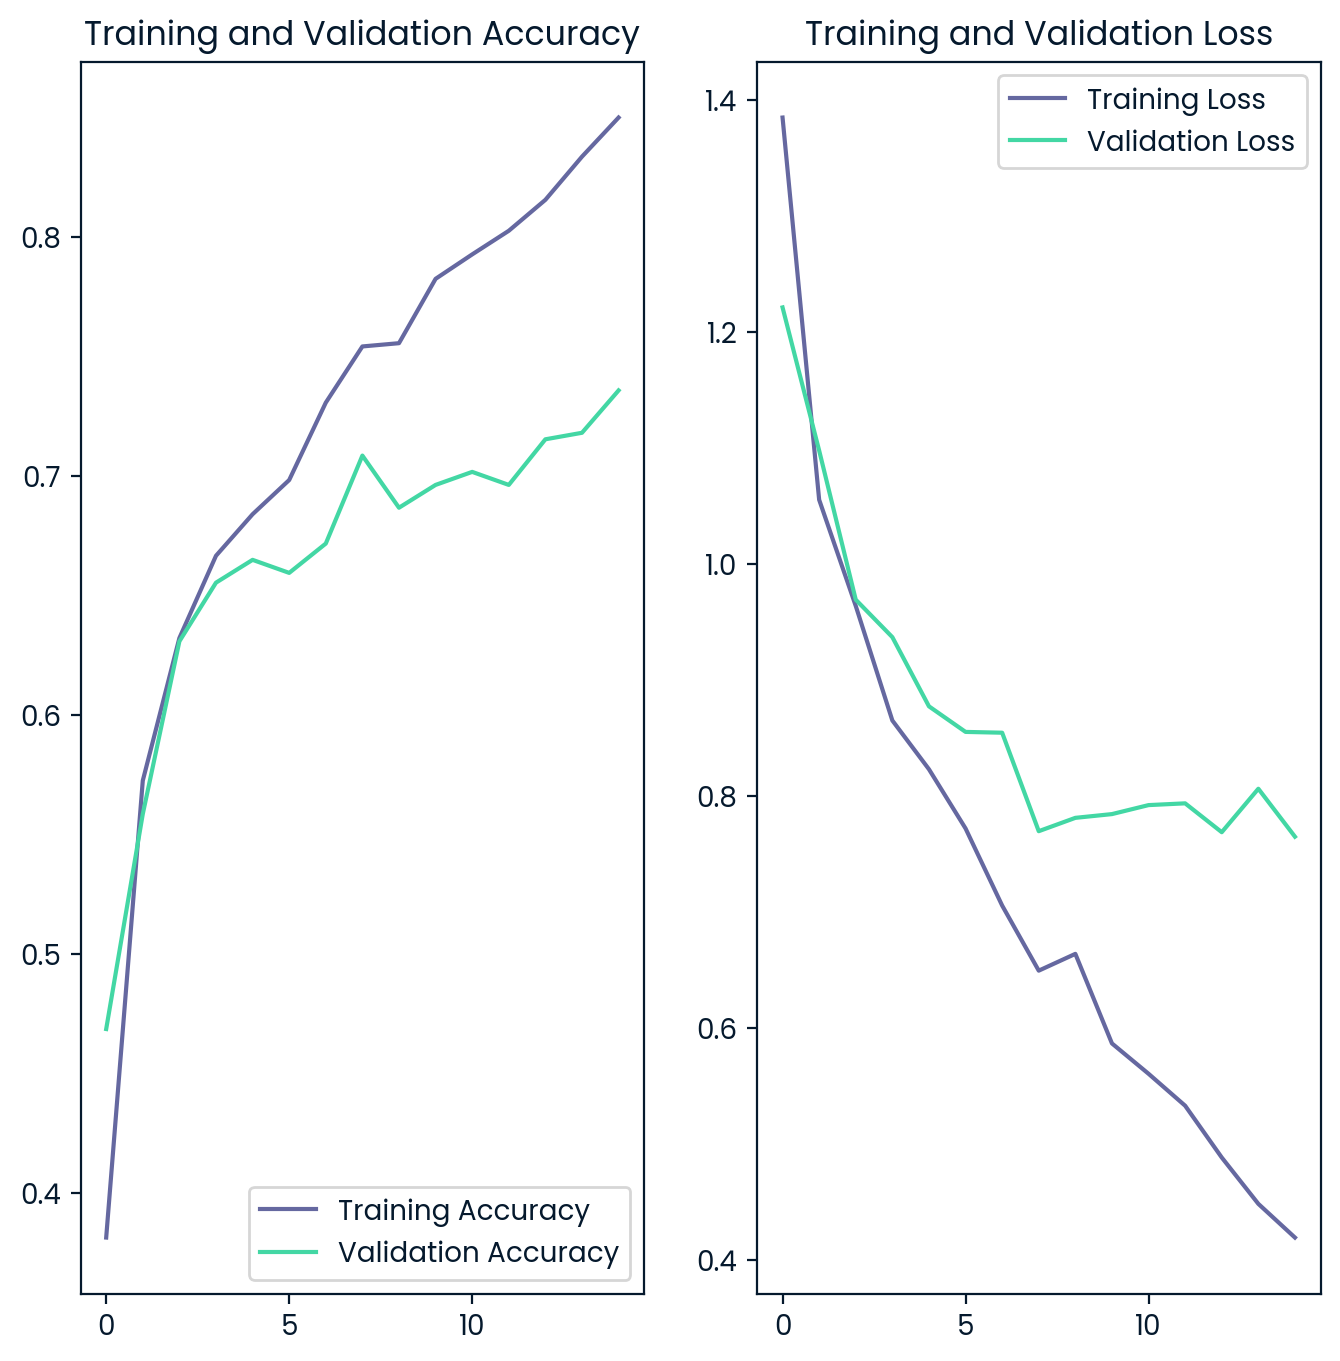

In [74]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [75]:
sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)

img = tf.keras.utils.load_img(sunflower_path, target_size=(img_height, img_width))
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

predictions=  model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

117948/117948 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
This image most likely belongs to sunflowers with a 99.48 percent confidence.
